# Машинное обучение 1, ПМИ ФКН ВШЭ
## Семинар 19 (KNN)

# Проклятье размерности

Пусть есть выборка из многомерного равномерного распределения на гиперкубе $[0, 1]^d$
Рассмотрим объект $u$ в начале координат и будем считать окрестностью объекта $u$ "подкуб" со стороной $\epsilon$: $[0, \epsilon]^d$.

__Задача 1:__ 

C какой вероятностью объект выборки окажется в окрестности $u$? 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)})
sns.set_context("paper", font_scale=2) 


eps = 0.99

def generate_points(d):
    return np.random.uniform(size=([5000, d]))

$d = 1$, чему равна вероятность $p(x \in [0, eps]^d)$?

In [2]:
np.mean(generate_points(d=1) < eps)

0.9908

$d = 2$?

In [3]:
np.mean(generate_points(d=1).max(-1) < eps)

0.99

Посчитаем для произвольного d вероятность $p(x \in [0, \epsilon]^d)$ попасть в гиперкуб со стороной $\epsilon$

In [4]:
ds = []
probs = []
for d in range(1, 500):
    data = generate_points(d)
    ds.append(d)
    probs.append(np.mean(data.max(-1) < eps))
ds = np.array(ds)

Text(0, 0.5, 'Вероятность найти соседа')

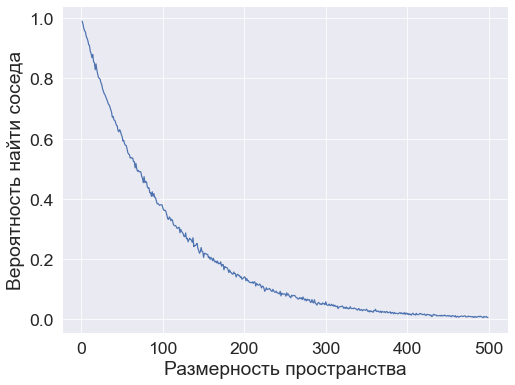

In [5]:
plt.plot(ds, probs)
plt.xlabel("Размерность пространства")
plt.ylabel("Вероятность найти соседа")

Можно оценить вероятность формулой?

Text(0, 0.5, 'Вероятность найти соседа')

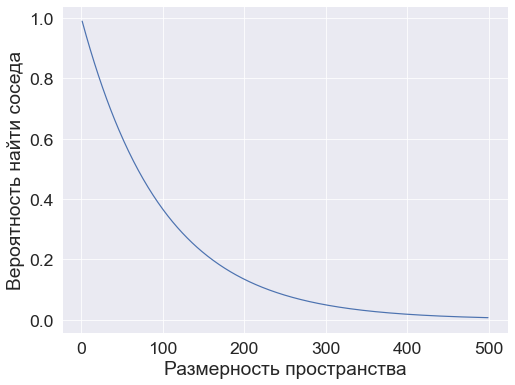

In [6]:
plt.plot(ds, (eps / 1.0)**np.array(ds))
plt.xlabel("Размерность пространства")
plt.ylabel("Вероятность найти соседа")

__Задача 2__ 

Найдем теперь такое значение объема $\delta(k)=\epsilon^d$, что вероятность того, что найдутся хотя бы $k=5$ объектов внутри этого объема > $0.95$

найти $\min \delta$ такое, что $\sum_{k=5}^{5000} \binom{5000}{k} \delta^k (1 - \delta)^{5000 - k} > 0.95$

Или что тоже самое, найти   $\min \delta$: 1 - $\sum_{k=0}^{4} \binom{5000}{k} \delta^k (1 - \delta)^{5000 - k} > 0.95$

Text(0, 0.5, 'Вероятность встретить хотя бы 5 соседей')

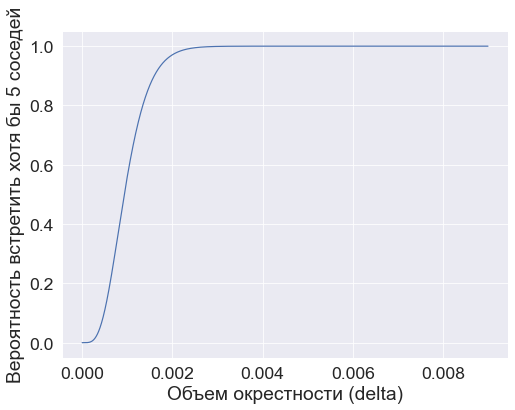

In [7]:
from scipy.special import binom

k = 5
coeffs = np.array([binom(5000, k) for k in range(k)])

def volume2prob(delta):
    prob = 1 - np.sum(coeffs * np.array([delta**i for i in range(k)]) * \
            np.array([(1 - delta)**(5000 - i) for i in range(k)]))
    return prob

delta_range = np.linspace(0, 0.009, 3000)
probs = [volume2prob(delta) for delta in delta_range]
plt.plot(delta_range, probs)
plt.xlabel("Объем окрестности (delta)")
plt.ylabel("Вероятность встретить хотя бы 5 соседей")

Как видим, функция монотонно возрастает, можем найти $\min \delta$ бинпоиском.

In [8]:
from bisect import bisect


class LazyProb:
    def __init__(self):
        self.delta_range = np.linspace(0, 0.01, 3000)
        
    def __getitem__(self, i, n=5000):
        prob = volume2prob(self.delta_range[i])
        return prob

    def __len__(self):
        return len(self.delta_range)

grid = LazyProb()
print("delta", f"= {grid.delta_range[bisect(grid, 0.95)]:.4f}")

delta = 0.0018


Вспомним как зависит $\delta$ от $\epsilon$:
$\delta = \epsilon^d$

Значит по каждой координате нажно отступить на $0.0018^{1/d}$. Получаем, что с ростом размерности необходимо увеличивать объем окрестности, чтобы были хоть какие-то соседи:

Text(0, 0.5, 'Длина стороны гиперкуба')

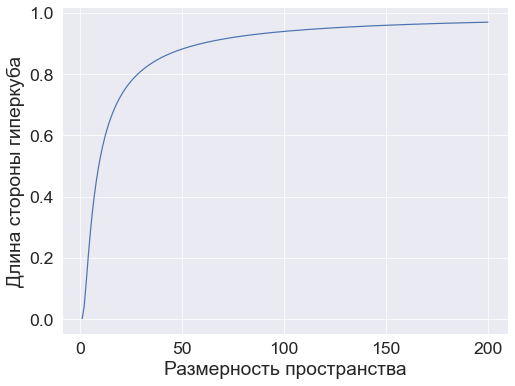

In [9]:
plt.plot(ds[:200], 0.0018**(1/ds)[:200])
plt.xlabel("Размерность пространства")
plt.ylabel("Длина стороны гиперкуба")

Как же быть, если данные большой размерности?

# Функции расстояния

### Расстояние Минковского

Посмотрим на метрику Минковского:

$$ \rho_p(x, y, w) = \left(\sum_j w_j |x_j - y_j|^p \right)^{1/p} $$

Рассмотрим расстояние до $y=0$:
$$ f(x) = \rho_p(x, 0, w) = \left(\sum_j w_j |x_j|^p \right)^{1/p}$$

__Вопрос__: Как будут выглядеть линии уровня функции $f(x)$ при разных $p$?

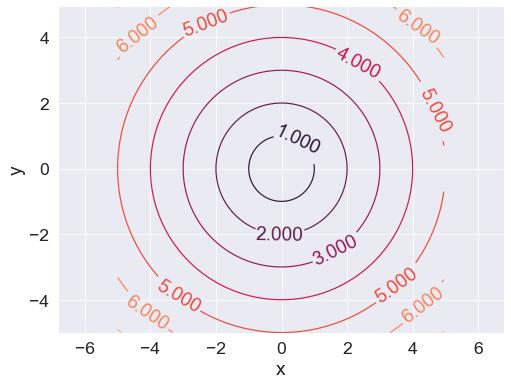

In [10]:
import pylab
import numpy
plt.axis('equal')

##############
# (ﾉ◕ヮ◕)ﾉ*:･ﾟ✧

wx = 1
wy = 1
p = 2
##############

def pdist_from_0(x, y, p=2):
    assert p >= 1
    return np.power(wx * np.power(np.abs(x), p) + wy * np.power(np.abs(y), p), 1/p)

def makeData(p):
    x = numpy.arange(-5, 5, 0.05)
    y = numpy.arange(-5, 5, 0.05)
    
    xgrid, ygrid = numpy.meshgrid(x, y)

    zgrid = pdist_from_0(xgrid, ygrid, p)
    
    return xgrid, ygrid, zgrid

x, y, z = makeData(p=p)


cs = pylab.contour(x, y, z)
pylab.clabel(cs)
plt.xlabel("x")
plt.ylabel("y")

pylab.show()

Во что превращается метрика Минковского, если $p \rightarrow \infty$?

$$  \rho_{\infty}(x, y, w) = \max_j w_j |x_j - y_j|$$

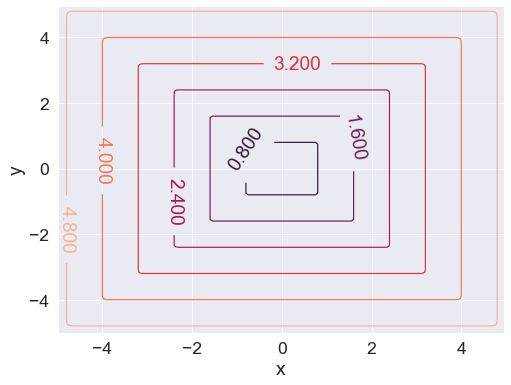

In [12]:
x, y, z = makeData(p=100)


cs = pylab.contour(x, y, z)
pylab.clabel(cs)
plt.xlabel("x")
plt.ylabel("y")

pylab.show()

### Расстояние Махалонобиса

Пусть есть выборка из многомерного нормального распределения. Для простоты предположим, что она центрирована. Мы хотим для нового объекта оценить "расстояние" от какого-то нового объекта до выборки. Это можно делать разными способами, обсудим один из них.

Логично было бы считать расстоянием от точки до выборки расстояние от точки до центра масс. Рассмотрим пример:

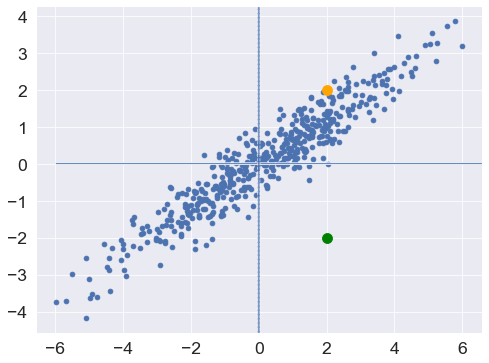

In [13]:
np.random.seed(0)
cluster = np.random.multivariate_normal(
    mean=[0, 0], 
    cov=[[5, 3], 
         [3, 2]], size=(500,))
plt.scatter(cluster[:,0], cluster[:,1])
plt.scatter([2], [-2], c="green", s=100)
plt.scatter([2], [2], c="orange", s=100)
plt.arrow(-6, 0, 13, 0,
         width = 0.05,
         head_length = 0.5)
plt.arrow(0, -6, 0, 12,
         width = 0.07,
         head_length = 0.5, linestyle="--", alpha=0.7)

$\rho_2$ расстояние до центра кластера от двух точек одинаковое, но хорошо ли это?

Хотим как-то изменить функцию расстояния. Тут нам придет на помощь расстояние Махалонобиса.

$$ \rho(x, y) = \sqrt{(x - y)^T S^{-1} (x - y)}  $$

что представляют из себя линии уровня такой функции?

Для матрицы $S$ можно произвести [спектральное разложение](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B5%D0%BA%D1%82%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D0%B7%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D1%8B):

$$ S = V \Lambda V^T $$
$$ V_{i} - \text{столбец - собственный вектор}$$
$$ \Lambda_{ii} - \text{собственное знечение}$$

$$ x^T S^{-1} x = x^T (V \Lambda V^T)^{-1} x = x^T V \, \Lambda^{-1} 
\,V^T x= (V^T x)^T \Lambda^{-1} (V^T x) = x'^T \Lambda^{-1} x'$$

В новых координатах получили $\rho_2(x', 0, [\lambda_1^1, \ldots, \lambda_d^{-1}])$

In [21]:
(cluster.T @ cluster) / (cluster.shape[0] - 1)

array([[4.76414323, 2.86259037],
       [2.86259037, 1.92074679]])

In [22]:
S = (cluster.T @ cluster) / (cluster.shape[0] - 1)

In [23]:
from numpy import linalg

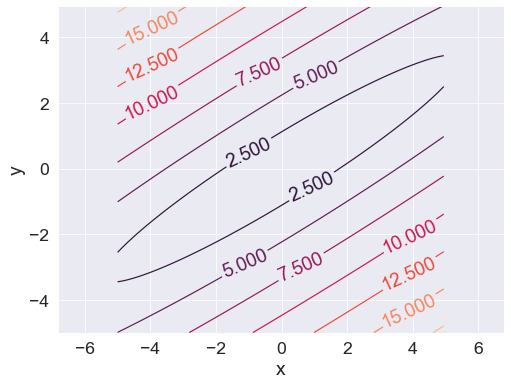

In [25]:
import pylab
import numpy

##############
# (づ｡◕‿‿◕｡)づ 

wx = 1
wy = 1

# Зададим V как матрицу поворота на угол theta
theta = 0
Rotate = np.array([[np.cos(theta), np.sin(theta)],
                   [-np.sin(theta), np.cos(theta)]])

S_inv = linalg.inv(S) #Rotate @ np.array([[10, 0], 
         #                  [0, 1]]) @ Rotate.T
##############

def mahalonobis_from_0(x, y, p=2):
    assert p >= 1
    X = np.concatenate((x[:,:,None], y[:,:,None]), axis=-1)
    X = X[:,:,None,:] @ S_inv[None, None, :, :] @ X[:,:,:,None]
    X = X.squeeze()
    return np.sqrt(X)

def makeData(p):
    x = numpy.arange(-5, 5, 0.05)
    y = numpy.arange(-5, 5, 0.05)
    
    xgrid, ygrid = numpy.meshgrid(x, y)

    zgrid = mahalonobis_from_0(xgrid, ygrid, p)
    
    return xgrid, ygrid, zgrid



x, y, z = makeData(p=2)
cs = pylab.contour(x, y, z)
pylab.clabel(cs)
plt.axis('equal')
plt.xlabel("x")
plt.ylabel("y")

pylab.show()

<a list of 10 text.Text objects>

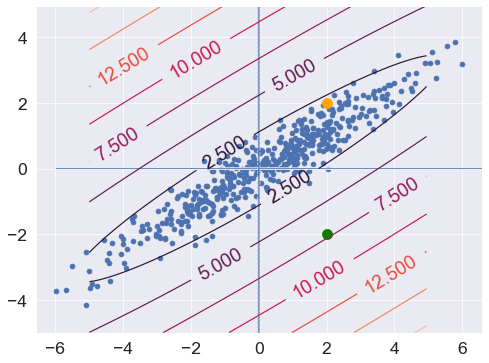

In [15]:
np.random.seed(0)
cluster = np.random.multivariate_normal(
    mean=[0, 0], 
    cov=[[5, 3], 
         [3, 2]], size=(500,))
plt.scatter(cluster[:,0], cluster[:,1])
plt.scatter([2], [-2], c="green", s=100)
plt.scatter([2], [2], c="orange", s=100)
plt.arrow(-6, 0, 13, 0,
         width = 0.05,
         head_length = 0.5)
plt.arrow(0, -6, 0, 12,
         width = 0.07,
         head_length = 0.5, linestyle="--", alpha=0.7)

S_inv = np.linalg.inv(cluster.T @ cluster / (len(cluster - 1)))
x, y, z = makeData(p=2)
cs = pylab.contour(x, y, z)
pylab.clabel(cs)